# Heat Event Identification

## Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import sys
import os

# Update paths to get source code from notebook_utils
curr_dir = os.path.dirname(os.path.abspath('notebooks'))
proj_dir = os.path.dirname(curr_dir)
src_path = os.path.join(proj_dir, 'src')
sys.path.append(src_path)

from notebook_utils.preprocessing import *
from notebook_utils.heat_identification import *

# Create combined dataframe from ghcn_cleaned files
CA_stations_dfs = combine_files_to_dfs('../data/processed/ghcn_cleaned')

Processed file: CA_2003_clean.csv
Processed file: CA_2004_clean.csv
Processed file: CA_2005_clean.csv
Processed file: CA_2006_clean.csv
Processed file: CA_2007_clean.csv
Processed file: CA_2008_clean.csv
Processed file: CA_2009_clean.csv
Processed file: CA_2010_clean.csv
Processed file: CA_2011_clean.csv
Processed file: CA_2012_clean.csv
Processed file: CA_2013_clean.csv
Processed file: CA_2014_clean.csv
Processed file: CA_2015_clean.csv
Processed file: CA_2016_clean.csv
Processed file: CA_2017_clean.csv
Processed file: CA_2018_clean.csv
Processed file: CA_2019_clean.csv
Processed file: CA_2020_clean.csv
Processed file: CA_2021_clean.csv
Processed file: CA_2022_clean.csv
Processed file: CA_2023_clean.csv


# Heat Event Definition

1. CTX95pct. The threshold is the calendar day 95th percentile of Tmax based on a 15-day window centered on a given day; that is, there is a different percentile threshold for each day of the year to account for the seasonal cycle.

Source for heat event and heat metric definitions: Hulley, G.C., Dousset, B. and Kahn, B.H., 2020. Rising trends in heatwave metrics across southern California. Earth's Future, 8(7), p.e2020EF001480.

### Extract Daily Maximum and Minimum

In [2]:
CA_stations_dfs['datetime'] = pd.to_datetime(CA_stations_dfs['datetime'])
CA_stations_dfs['Date'] = CA_stations_dfs['datetime'].dt.date

# Calculate daily maximum and minimum temperatures
daily_temp = CA_stations_dfs.groupby(['Station_name', 'Latitude', 'Longitude', 'Date']).agg( Tmax =('Temperature', 'max')).reset_index()

# Identify Heat Events

### Calculate 95th percentile for Tmax and Tmin Based on 15-Day Window

In [3]:
def calc_rolling_percentile(series, window_size=15, percentile=95):
    return series.rolling(window=window_size, center=False).quantile(percentile / 100)

# Calculate 95th percentile of daily maximum and minimum temperatures
daily_temp['CTX95pct'] = daily_temp.groupby('Station_name')['Tmax'].apply(calc_rolling_percentile).reset_index(drop=True)

### Find Heat Events

In [4]:
# Identify heat events based on 95th percentile of daily maximum and minimum temperatures
daily_temp['heat_event'] = daily_temp['Tmax'] > daily_temp['CTX95pct']

In [5]:
daily_temp.tail()

,Station_name,Latitude,Longitude,Date,Tmax,CTX95pct,heat_event
581522,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-05-27,22.1,26.25,False
581523,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-05-28,20.9,25.82,False
581524,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-05-29,21.4,25.82,False
581525,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-05-30,20.8,25.82,False
581526,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-05-31,21.0,25.14,False


# Heat Event Metrics

* Frequency: number of heatwaves per year within detection window.
* Duration: total number of contiguous days from start to end of heatwave event.
* Intensity: maximum temperature during a heatwave event minus the 95th percentile climatology of temperatures for a 15-day window centered on the heatwave event.
(Hulley, 2020)

### Identify Heat Event Groups

In [12]:
daily_temp.loc[:, 'heat_event_change'] = daily_temp['heat_event'].shift(1, fill_value=False) != daily_temp['heat_event']

daily_temp.loc[:, 'heat_event_group'] = (daily_temp['heat_event_change'] & daily_temp['heat_event']).cumsum()

daily_temp.loc[:, 'heat_event_group'] = daily_temp['heat_event_group'].where(daily_temp['heat_event'], np.nan).ffill()
daily_temp.dropna(subset=['heat_event_group'], inplace=True)

daily_temp.drop(columns=['heat_event_change'], inplace=True)

valid_groups = daily_temp.groupby('heat_event_group').filter(lambda x: len(x) >= 3)
valid_groups.reset_index(drop=True, inplace=True)

valid_groups

C:\Users\lizbe\AppData\Local\Temp\ipykernel_6824\623060272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_temp.loc[:, 'heat_event_change'] = daily_temp['heat_event'].shift(1, fill_value=False) != daily_temp['heat_event']
C:\Users\lizbe\AppData\Local\Temp\ipykernel_6824\623060272.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_temp.dropna(subset=['heat_event_group'], inplace=True)
C:\Users\lizbe\AppData\Local\Temp\ipykernel_6824\623060272.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

,Station_name,Latitude,Longitude,Date,Tmax,CTX95pct,heat_event,heat_event_group
0,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-17,16.6,16.46,True,1
1,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-25,17.1,16.75,True,1
2,ALTURAS MUNI AP,41.4836,-120.5614,2003-01-31,18.8,17.61,True,1
3,ALTURAS MUNI AP,41.4836,-120.5614,2003-02-21,16.3,15.60,True,1
4,ALTURAS MUNI AP,41.4836,-120.5614,2003-02-22,17.2,16.57,True,1
...,...,...,...,...,...,...,...,...
51204,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-10,22.2,21.78,True,1
51205,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-21,24.5,22.89,True,1
51206,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-26,24.7,24.56,True,1
51207,YOSEMITE VILLAGE 12 W,37.7592,-119.8208,2023-04-27,25.8,25.03,True,1


In [7]:
# Count the number of unique heat event groups per year
heatwave_freq = daily_temp[daily_temp['heat_event']]['Date'].dt.year.value_counts().sort_index()
# Duration of each heatwave event in days
heatwave_durations = daily_temp[daily_temp['heat_event']].groupby('heat_event_group').size().reset_index(name='duration')
# Calculate the maximum temperature during each heatwave event
daily_temp['heatwave_max_temp'] = daily_temp.groupby('heat_event_group')['Tmax'].transform('max')

# Calculate intensity for each heatwave event
heatwave_intensity = daily_temp[daily_temp['heat_event']].groupby('heat_event_group').agg({
    'heatwave_max_temp': 'max',
    'CTX95pct': 'mean'
}).reset_index()
heatwave_intensity['intensity'] = heatwave_intensity['heatwave_max_temp'] - heatwave_intensity['CTX95pct']


AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
heat_event_metrics

,Station_name,heat_event_group,frequency,duration,Tmax_intensity,Year
0,ALTURAS MUNI AP,2.0,14,14,0.28,2003
1,ALTURAS MUNI AP,4.0,13,13,1.19,2003
2,ALTURAS MUNI AP,6.0,9,9,0.14,2003
3,ALTURAS MUNI AP,8.0,16,16,0.63,2003
4,ALTURAS MUNI AP,10.0,20,20,0.70,2003
...,...,...,...,...,...,...
28421,YOSEMITE VILLAGE 12 W,56690.0,15,15,0.07,2019
28422,YOSEMITE VILLAGE 12 W,56692.0,23,23,0.77,2019
28423,YOSEMITE VILLAGE 12 W,56694.0,17,17,0.42,2019
28424,YOSEMITE VILLAGE 12 W,56696.0,16,16,0.63,2019


# Calculate Trends for Heat Events

# Identify California-wide Heat Events

# Visualize Heat Events

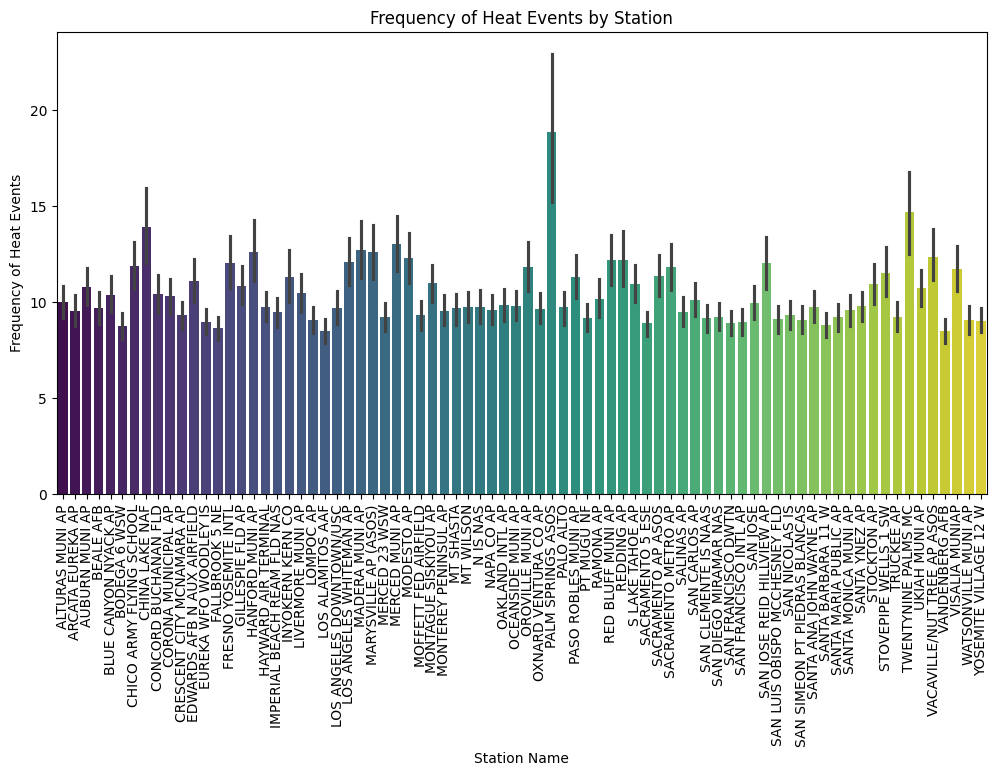

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'frequency' is the count of heat events per station
plt.figure(figsize=(12, 6))
sns.barplot(data=heat_event_metrics, x='Station_name', y='frequency', palette='viridis', hue='Station_name')
plt.xticks(rotation=90)
plt.title('Frequency of Heat Events by Station')
plt.xlabel('Station Name')
plt.ylabel('Frequency of Heat Events')
plt.show()

